# Seminar 3.1: Fine-tuning CNNs

This notebook reviews the process of **fine-tuning** a CNN pretrained for task A for to solve a different task B. This is also known as **transfer learning**.

The rest of this notebook will guide you through the following:

1. Review the target task B (telling cats from dogs on images).
2. Download a CNN that has been pretrained to solve a far more complex task A (1000-class [ImageNet](http://image-net.org/) classification).
3. Try classifying CNN's outputs by classical machine learning to solve task B (use CNN as a black box feature extractor).
4. Replace CNN's last (linear) layer and train only that layer for task B (use CNN's first layers as a black box feature extractor).
5. Train (*fine-tune*) the whole network for task B.

### 1. Dogs vs Cats Dataset

Download the dataset:

In [1]:
import os
from urllib.request import urlretrieve

if not os.path.exists("dogs_vs_cats.train.zip"):
    urlretrieve(
        "https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1",
        "dogs_vs_cats.train.zip")

if not os.path.exists("dogs_vs_cats"):
    import zipfile
    with zipfile.ZipFile("dogs_vs_cats.train.zip", 'r') as archive:
        archive.extractall("dogs_vs_cats")

Split train/val and move to subfolders:

In [3]:
dataset_root = "dogs_vs_cats"

os.makedirs(os.path.join(dataset_root, "train", "dog"), exist_ok=True)
os.makedirs(os.path.join(dataset_root, "train", "cat"), exist_ok=True)

os.makedirs(os.path.join(dataset_root, "val", "dog"), exist_ok=True)
os.makedirs(os.path.join(dataset_root, "val", "cat"), exist_ok=True)

for filename in os.listdir(os.path.join(dataset_root, "train")):
    if filename.endswith(".jpg"):
        class_name = filename[:3] # "dog" or "cat"
        image_idx = int(filename[4:-4])
        if image_idx % 40 == 0:
            split = "train"
        elif image_idx % 40 == 1:
            split = "val"
        else:
            os.remove(os.path.join(dataset_root, "train", filename))
            continue
        
        os.rename(
            os.path.join(dataset_root, "train", filename),
            os.path.join(dataset_root, split, class_name, filename))

Explore the dataset:

In [4]:
import torch
import torchvision

train_dataset = torchvision.datasets.ImageFolder(
    os.path.join(dataset_root, "train"),
    transform=None) # or =torchvision.transforms.ToTensor())

val_dataset = torchvision.datasets.ImageFolder(
    os.path.join(dataset_root, "val"),
    transform=None) # or =torchvision.transforms.ToTensor())

In [5]:
len(train_dataset), len(val_dataset)

(626, 626)

<class 'PIL.Image.Image'>
cat
Image size: (500, 374)


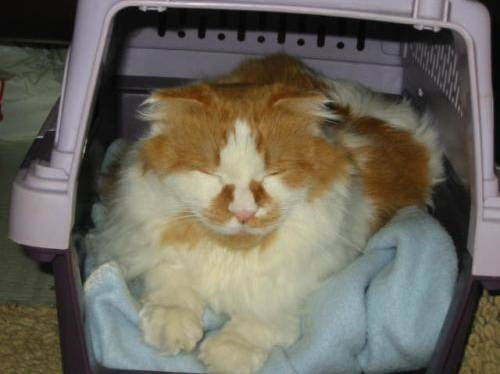

In [6]:
image, label = train_dataset[100]
print(type(image))
print("cat" if label == 0 else "dog")
print("Image size:", image.size)
image

### 2. CNNs pretrained on the *ImageNet* dataset

#### 2.1 The ImageNet challenge

In [17]:
import requests

# ImageNet class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
class_names = sorted(list(requests.get(LABELS_URL).json().items()), key=lambda x: int(x[0]))
class_names = list(map(lambda x: x[1], class_names))
n_classes = len(class_names)

In [18]:
import random

print("Total %d classes; examples:" % n_classes)
for _ in range(10):
    class_idx = random.randint(0, len(class_names))
    print("Class %d: %s" % (class_idx, class_names[class_idx]))

Total 1000 classes; examples:
Class 706: patio, terrace
Class 206: curly-coated retriever
Class 510: container ship, containership, container vessel
Class 613: joystick
Class 976: promontory, headland, head, foreland
Class 317: leafhopper
Class 234: Rottweiler
Class 281: tabby, tabby cat
Class 364: three-toed sloth, ai, Bradypus tridactylus
Class 902: whistle


#### 2.2 Pretrained CNNs

In [2]:
help(torchvision.models)

Let's use for example the ["SqueezeNet"](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py) network:

<img src="https://cdn-images-1.medium.com/max/800/1*xji5NAhX6m3Nk7BmR_9GFw.png" width=650>

In [330]:
?torchvision.models.SqueezeNet

In [331]:
?torchvision.models.squeezenet1_0

In [3]:
model = torchvision.models.squeezenet1_0(
    pretrained=True,
    num_classes=1000)

Call `.eval()` if you want to do forward passes; if you want to train the model, call `.train()`. These calls change the behavior of some layers, for instance dropout or batch normalization.

In [ ]:
model.eval()

In [333]:
# try to forward some garbage through the model
# note: SqueezeNet only accepts 224x224 images
sample_input = torch.randn(5, 3, 224, 224)
sample_output = model(sample_input)

In [334]:
# the output is class scores:
# (number of images per batch) x (number of classes)
sample_output.shape

torch.Size([5, 1000])

In [335]:
sample_output.min(), sample_output.max()

(tensor(0., grad_fn=<MinBackward1>), tensor(8.1576, grad_fn=<MaxBackward1>))

Try to classify some images from `./sample_images/`:

In [10]:
# See https://pytorch.org/docs/stable/torchvision/models.html
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

In [11]:
def PIL_to_pytorch(image):
    return torch.tensor(image.getdata()).view(image.size + (3,))

def predict(image):
    """
        image: PIL image
        
        returns: ImageNet class probabilities
    """
    image = PIL_to_pytorch(image)
    image = image.permute(2, 0, 1)
    image = image.to(torch.float32)
    image /= 255.0
    
    # normalize
    image -= imagenet_mean[:, None, None]
    image /= imagenet_std [:, None, None]
    
    # add singleton batch dimension with [None]
    prediction = model(image[None])
    # 1 x 1000
    prediction = prediction.softmax(1)
    
    # remove singleton dimension with [0]
    return prediction[0]

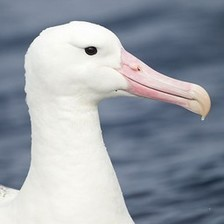

In [4]:
import PIL.Image

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
image_path = \
    "./dogs_vs_cats/train/dog/dog.0.jpg" if IN_COLAB else \
    "./sample_images/albatross.jpg"

image = PIL.Image.open(image_path).resize((224, 224))
image

In [19]:
prediction = predict(image)

In [20]:
probabilities = predict(image)

top_probabilities, top_indices = torch.topk(probabilities, 10)
print("10 most probable classes are:")
for probability, class_idx in zip(top_probabilities, top_indices):
    print("%.4f: %s" % (probability, class_names[class_idx]))

10 most probable classes are:
0.9826: albatross, mollymawk
0.0161: goose
0.0007: American egret, great white heron, Egretta albus
0.0003: spoonbill
0.0001: ptarmigan
0.0001: pelican
0.0000: sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
0.0000: crane
0.0000: drake
0.0000: flamingo


### 3. Use classical machine learning with a pretrained CNN

This is the last block of our network (you learn this by reading model's `forward()` in the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)):

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.5)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace)
  (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
)

You can see that the last block accepts a 13x13 512-channel image, converts it to 1000 channels by a linear layer (Conv2d with 1x1 kernel), and takes average over each channel to obtain class scores. 

Let's make the last layer do just average pooling instead of the above. This way the model will now return the "raw" image features called **embeddings**.

In [22]:
average_pooling = model.classifier[3]

# the new "number of classes" is 512:
model.num_classes = model.classifier[1].in_channels

model.classifier = average_pooling

In [23]:
sample_input = torch.randn(5, 3, 224, 224)
sample_embedding = model(sample_input)

In [24]:
sample_embedding.shape

torch.Size([5, 512])

These raw embeddings can already be good features for telling cats from dogs.

But first let's set up image loaders with proper preprocessing.

In [25]:
train_dataset = torchvision.datasets.ImageFolder(
    os.path.join(dataset_root, "train"),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=imagenet_mean, std=imagenet_std)]
    )
)

val_dataset = torchvision.datasets.ImageFolder(
    os.path.join(dataset_root, "val"),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=imagenet_mean, std=imagenet_std)]
    )
)

In [19]:
?torch.utils.data.DataLoader

In [26]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

In [27]:
!pip install --user tqdm
from tqdm import tqdm_notebook as tqdm

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
import numpy as np

In [29]:
model.cuda();

Let's compute embeddings for the whole dataset.

In [50]:
X_train = np.empty((len(train_dataset), sample_embedding.shape[1]), dtype=np.float32)
y_train = np.empty(len(train_dataset), dtype=np.int64)

with torch.no_grad():
    for batch_idx, (image_batch, labels_batch) in enumerate(tqdm(train_loader)):
        embedding_subarray = X_train[batch_idx*batch_size : (batch_idx+1)*batch_size]
        labels_subarray    = y_train[batch_idx*batch_size : (batch_idx+1)*batch_size]
        
        embeddings = model(image_batch.cuda())
        np.copyto(embedding_subarray, embeddings.cpu().numpy())
        np.copyto(labels_subarray, labels_batch.numpy())

In [51]:
X_val = np.empty((len(val_dataset), sample_embedding.shape[1]), dtype=np.float32)
y_val = np.empty(len(val_dataset), dtype=np.int64)

with torch.no_grad():
    for batch_idx, (image_batch, labels_batch) in enumerate(tqdm(val_loader)):
        embedding_subarray = X_val[batch_idx*batch_size : (batch_idx+1)*batch_size]
        labels_subarray    = y_val[batch_idx*batch_size : (batch_idx+1)*batch_size]
        
        embeddings = model(image_batch.cuda())
        np.copyto(embedding_subarray, embeddings.cpu().numpy())
        np.copyto(labels_subarray, labels_batch.numpy())

In [353]:
X_train.shape, X_val.shape

((626, 512), (626, 512))

In [ ]:
# Train a classifier on precomputed embeddings
import sklearn.ensemble
import sklearn.metrics

classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X_train, y_train);

In [53]:
print("Train accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, classifier.predict(X_train)) * 100))
print("Val accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_val, classifier.predict(X_val)) * 100))

Train accuracy: 99.68
Val accuracy: 90.26


### 4. Replace the last layer and retrain it

The above approach isn't very convenient because we have to run a separate algorithm.

A more convenient solution is to add a neural network on top of our CNN that would classify cats vs dogs itself. This way, our pipeline becomes **end-to-end**: a single CNN directly outputs the prediction we need (the probability of "dog" class).

Here, I replace the last layer with a simple logistic regression (one linear layer), so the accuracy won't be much higher than with random forest. However, nothing stops you from adding a more powerful classifier, e.g. multilayer perceptron.

In [30]:
# a custom layer to reshape a tensor into batch of vectors
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.flatten(1)
    
model.classifier = torch.nn.Sequential(
    average_pooling,
    Flatten(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Linear(512, 1),
).cuda()

model.num_classes = 1

We only need to train the last layer, so others need to be "frozen":

In [31]:
for parameter in model.parameters():
    parameter.requires_grad_(False)

trainable_parameters = list(model.classifier.parameters())
for parameter in trainable_parameters:
    parameter.requires_grad_(True)

Let's train `model.classifier`:

In [32]:
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-3, weight_decay=1e-4)
loss = torch.nn.BCEWithLogitsLoss()

In [33]:
def validate(model, dataloader):
    """ Compute accuracy on a dataset """
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            probabilities = model(images.cuda()).cpu().flatten()
            predictions = (probabilities > 0.5).long()

            total += len(labels)
            correct += (predictions == labels).sum().item()
            
    return correct / total

def train(model, dataloader, loss, optimizer):
    """ Train for one epoch """
    model.train()
    correct, total = 0, 0
    total_loss = 0.0
    
    for idx, (images, labels) in enumerate(dataloader):
        probabilities = model(images.cuda()).cpu().flatten()
        
        with torch.no_grad():
            predictions = (probabilities > 0.5).long()
            total += len(labels)
            correct += (predictions == labels).sum().item()
        
        loss_value = loss(probabilities, labels.float())
        total_loss += loss_value.item() * len(labels)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    
    return correct / total, total_loss / total

In [58]:
for epoch in range(20):
    train_accuracy, train_loss = train(model, train_loader, loss, optimizer)
    val_accuracy = validate(model, val_loader)
    print("Epoch %d, train %.2f%% (loss %.4f), val %.2f%%" \
            % (epoch, train_accuracy * 100, train_loss, val_accuracy * 100))

Epoch 0, train 60.86% (loss 0.6133), val 65.02%
Epoch 1, train 75.40% (loss 0.4866), val 77.48%
Epoch 2, train 82.75% (loss 0.4031), val 82.59%
Epoch 3, train 86.42% (loss 0.3449), val 85.14%
Epoch 4, train 88.98% (loss 0.3042), val 86.74%
Epoch 5, train 89.46% (loss 0.2877), val 87.54%
Epoch 6, train 90.89% (loss 0.2540), val 88.66%
Epoch 7, train 91.21% (loss 0.2395), val 89.62%
Epoch 8, train 92.33% (loss 0.2204), val 91.37%
Epoch 9, train 92.81% (loss 0.2159), val 91.37%
Epoch 10, train 92.49% (loss 0.2021), val 91.21%
Epoch 11, train 93.45% (loss 0.1921), val 91.85%
Epoch 12, train 94.73% (loss 0.1806), val 91.85%
Epoch 13, train 94.89% (loss 0.1721), val 91.85%
Epoch 14, train 94.57% (loss 0.1689), val 91.85%
Epoch 15, train 93.77% (loss 0.1630), val 92.33%
Epoch 16, train 94.73% (loss 0.1650), val 92.33%
Epoch 17, train 95.69% (loss 0.1438), val 92.49%
Epoch 18, train 95.05% (loss 0.1494), val 92.65%
Epoch 19, train 95.69% (loss 0.1384), val 92.49%


### 5. Fine-tune the whole network

The "frozen" part is already a good feature extractor. However, it's not aware of our dataset. Let's train **all** layers (including our new retrofitted classifier) to get extra accuracy. This process is called **fine-tuning**.

Unfreeze all layers back:

In [57]:
for parameter in model.parameters():
    parameter.requires_grad_(True)

Because the original weights are valuable and fragile (because they are co-adapted to each other in different layers), we have to use a less aggressive optimizer (SGD with momentum in this case) and a much smaller learning rate than usually ($\leq$ 0.001 here, while on random weights I'd use something around 0.02).

In [58]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9,
    nesterov=True, weight_decay=1e-4)

In [1]:
for epoch in range(25):
    train_accuracy, train_loss = train(model, train_loader, loss, optimizer)
    val_accuracy = validate(model, val_loader)
    print("Epoch %d, train %.2f%% (loss %.4f), val %.2f%%" \
            % (epoch, train_accuracy * 100, train_loss, val_accuracy * 100))
    
    # gradually reduce learning rate
    for group in optimizer.param_groups:
        group['lr'] *= 0.9

Epoch 0, train 97.92% (loss 0.1026), val 92.49%
Epoch 1, train 97.12% (loss 0.0999), val 92.65%
Epoch 2, train 97.76% (loss 0.0994), val 92.65%
Epoch 3, train 97.76% (loss 0.0895), val 92.81%
Epoch 4, train 97.76% (loss 0.0824), val 92.81%
Epoch 5, train 98.40% (loss 0.0724), val 92.97%
Epoch 6, train 98.72% (loss 0.0707), val 93.13%
Epoch 7, train 99.20% (loss 0.0692), val 93.13%
Epoch 8, train 98.88% (loss 0.0667), val 93.45%
Epoch 9, train 98.56% (loss 0.0622), val 93.29%
Epoch 10, train 97.92% (loss 0.0665), val 92.97%
Epoch 11, train 99.04% (loss 0.0622), val 93.13%
Epoch 12, train 99.52% (loss 0.0535), val 93.45%
Epoch 13, train 99.20% (loss 0.0581), val 93.13%
Epoch 14, train 98.88% (loss 0.0598), val 93.13%
Epoch 15, train 99.68% (loss 0.0542), val 93.45%
Epoch 16, train 99.36% (loss 0.0525), val 93.13%
Epoch 17, train 98.72% (loss 0.0671), val 93.29%
Epoch 18, train 99.36% (loss 0.0609), val 93.29%
Epoch 19, train 99.36% (loss 0.0544), val 93.29%
Epoch 20, train 98.88% (loss 0